# First Assignment
## MSc course in Artificial Intelligence



In [1]:
# Initially, we clone the course repository
!rm -rf AI_USI_MA
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 391 (delta 48), reused 95 (delta 23), pack-reused 265
Receiving objects: 100% (391/391), 13.90 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (178/178), done.


In [2]:
# Let's prepare the environment by importing necessary libraries.
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import time as t
import matplotlib.pyplot as plt

################################################
# Depending on your execution environment, the way you import the required module will differ.

# If you are running this script locally on your machine, use the following import:
# from IO_manager.io_tsp import TSP_Instance_Creator
# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from solvers.constructive_algorithms import compute_length
# from solvers.local_search import TwoOpt
# from solvers.two_opt_with_candidate import twoOpt_with_cl

# However, if you are executing this notebook within Google Colab and the libraries are stored
# in a folder named 'AI_USI_MA', you should use the import statement below:
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.TSP_solver import Solver_TSP
from AI_USI_MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl




---
## Iterated Local Search (ILS) for the Traveling Salesman Problem (TSP)

The Iterated Local Search (ILS) is a metaheuristic that seeks to improve the quality of solutions by repeatedly applying a local search and introducing slight modifications (perturbations) to escape from local optima. This approach proves beneficial, especially for combinatorial problems like the Traveling Salesman Problem (TSP).

In this assignment, we will be focusing on solving the TSP using ILS for three benchmark instances:

1. **d198**: A standard instance known as 'd198.tsp' in TSP literature.
2. **pr439**: Another well-studied instance that will test the efficiency and efficacy of our ILS approach.
3. **u1060**: A relatively larger instance, serving as a comprehensive test for the scalability of our method.

Let's begin by loading and inspecting the 'd198.tsp' instance.


name: d198
nPoints: 198
best_sol: 15780.0


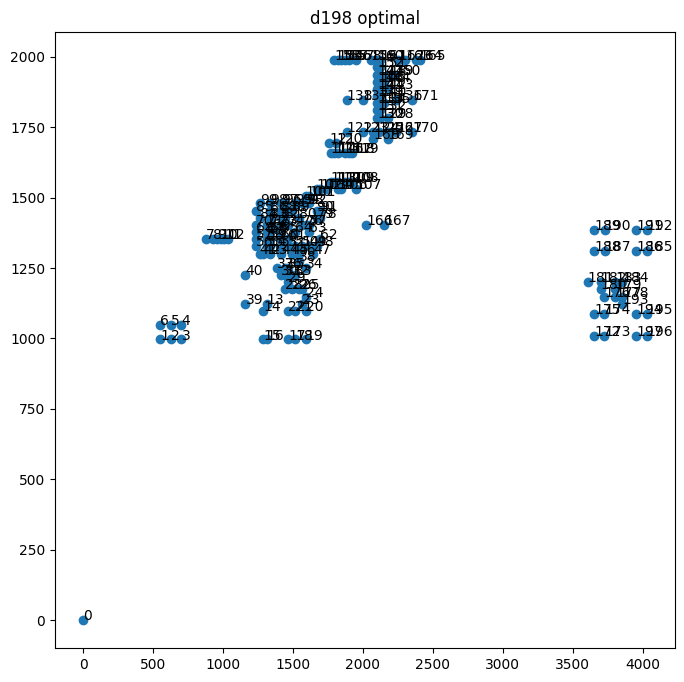

In [3]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

---
## 2-opt Algorithm for TSP

The 2-opt algorithm is a renowned local search method, predominantly utilized for refining solutions in the Traveling Salesman Problem (TSP). At its core, the algorithm takes a route and systematically swaps pairs of cities to ascertain if the change results in a shorter tour.

In this notebook, we furnish a black-box version of the 2-opt. For those embarking on its usage for the first time, we suggest revisiting our ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI_USI_MA/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa). It's paramount that any meta-heuristic, including 2-opt, complies with the specific input and output conventions laid out in the primary notebook.

For a tangible example, glance over the **naive_heuristic**. Within, the `TwoOpt.local_search` method is invoked to iteratively enhance the TSP solution.

Two instrumental aspects to note in our design are:
1. The `yield` statement: Serving as a generator, it permits the algorithm to produce solutions in phases, thus allowing exploration of a plethora of potential solutions without exhaustive execution.
2. The `ending_cond` (Ending Condition): Crafted to ensure the TSP Solver either ceases after 3 minutes or concludes when the local search achieves an optimum state via the heuristic.

---


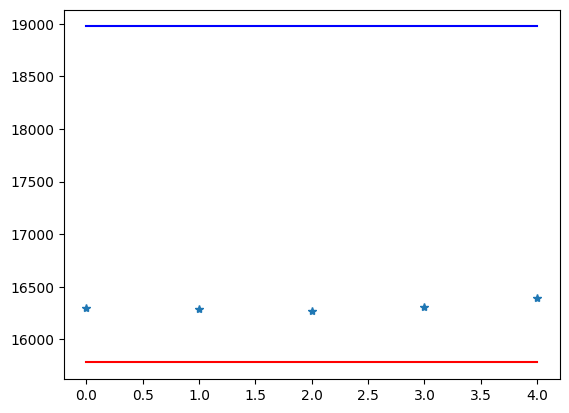

best gap with NN 20.25% on 1 trial,
with a total time of 0.004 seconds

best gap with random + 2opt 3.07% on 5 trials,
with a total time of 7.75 seconds


In [4]:
def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [5]:
import random
import numpy as np

class DoubleBridge:
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):

    cost_to_remove = matrix[solution[a-1], solution[a]] + matrix[solution[b-1], solution[b]] + matrix[solution[c-1], solution[c]] + matrix[solution[d-1], solution[d]]

    cost_to_add = matrix[solution[a-1], solution[c]] + matrix[solution[b-1], solution[d]] + matrix[solution[c-1], solution[a]] + matrix[solution[d-1], solution[b]]

    return cost_to_add - cost_to_remove

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    edges = random.sample(range(1, len(solution)), 4)
    edges = np.sort(edges)
    # print("edges: ",edges)

    a = edges[0]
    b = edges[3]
    c = edges[2]
    d = edges[1]

    difference_cost = DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
    # print("difference_cost: ", difference_cost)
    actual_cost += difference_cost

    solution = np.concatenate([solution[:a], solution[c:b], solution[d:c], solution[a:d], solution[b:]])
    # print(solution, compute_length(solution, matrix))
    return solution, actual_cost

In [6]:
# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 6.007024069182955
[ 0  8  9 10  2  3  4  5  6  7  1 11] 6.521769662814575


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw earlier in class.

To boost the time performances please use the cython class **two_opt_with_candidate**.

In [9]:
import random

def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    if ending_cond == True:
      break
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better


    #  in case you want to use twoOpt_with_cl
    # cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    # new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)

    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
      new_sol_perturbated, new_length_perperturbated = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      sol, cost = my_local_search(new_sol_perturbated, new_length_perperturbated, matrix)
      # sol, cost = twoOpt_with_cl(new_sol_perturbated, new_length_perperturbated, matrix, cl)

      # implement acceptance criterion
      if cost < best_cost:
        best_cost = cost
        best_sol = sol
        cost_sol_better.append(best_cost)

      ls_calls += 1

      yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    # cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    # new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)

    best_sol, best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
      new_sol_perturbated, new_length_perperturbated = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      best_sol, best_cost = my_local_search(new_sol_perturbated, new_length_perperturbated, matrix)
      # best_sol, best_cost = twoOpt_with_cl(new_sol_perturbated, new_length_perperturbated, matrix, cl)
      cost_sol_RW.append(best_cost)
      # implement acceptance criterion

      ls_calls += 1

      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    return

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    # cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    # new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)

    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1
    temperature = 100
    while True:

      # implement perturbation
      new_sol_perturbated, new_length_perperturbated = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      sol, cost = my_local_search(new_sol_perturbated, new_length_perperturbated, matrix)
      # sol, cost = twoOpt_with_cl(new_sol_perturbated, new_length_perperturbated, matrix, cl)

      # implement acceptance criterion
      if cost < best_cost:
        best_cost = cost
        best_sol = sol
        cost_sol_LSMC.append(best_cost)
      else:
        if np.exp((best_cost - cost)/temperature) > np.random.uniform(0, 1):
          best_cost = cost
          best_sol = sol
          cost_sol_LSMC.append(best_cost)

      ls_calls += 1
      # print("temperature: ", temperature)
      temperature = temperature*0.93


      yield best_sol, best_cost, ls_calls, False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task!

In [10]:
seeds= [0, 123, 333]
time_to_solve = 180 # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

names_instances = ["u1060.tsp"] #, "d198.tsp ,pr439.tsp", "u1060.tsp"

initializers = ["random"]
init_functions = [Random_Initializer.random_method]

improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

tour length  \
problem   optimal length method                                            seed                
u1060.tsp 224094.0       initialized with random, improved with ILS-better 0        241976.0   
                         initialized with random, improved with ILS-RW     0        243433.0   
                         initialized with random, improved with ILS-LSMC   0        244430.0   
                         initialized with random, improved with ILS-better 123      246391.0   
                         initialized with random, improved with ILS-RW     123      246412.0   
                         initialized with random, improved with ILS-LSMC   123      248169.0   
                         initialized with random, improved with ILS-better 333      246205.0   
                         initialized with random, improved with ILS-RW     333      248444.0   
                         initialized with random, improved with ILS-LSMC   333      247954.0   

                                                                                   gap  \
problem   optimal length method                                            seed          
u1060.tsp 224094.0       initialized with random, improved with ILS-better 0      7.98   
                         initialized with random, improved with ILS-RW     0      8.63   
                         initialized with random, improved with ILS-LSMC   0      9.07   
                         initialized with random, improved with ILS-better 123    9.95   
                         initialized with random, improved with ILS-RW     123    9.96   
                         initialized with random, improved with ILS-LSMC   123   10.74   
                         initialized with random, improved with ILS-better 333    9.87   
                         initialized with random, improved with ILS-RW     333   10.87   
                         initialized with random, improved with ILS-LSMC   333   10.65   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
u1060.tsp 224094.0       initialized with random, improved with ILS-better 0           259.786   
                         initialized with random, improved with ILS-RW     0           205.178   
                         initialized with random, improved with ILS-LSMC   0           308.013   
                         initialized with random, improved with ILS-better 123         411.774   
                         initialized with random, improved with ILS-RW     123         401.805   
                         initialized with random, improved with ILS-LSMC   123         387.152   
                         initialized with random, improved with ILS-better 333         233.063   
                         initialized with random, improved with ILS-RW     333         276.265   
                         initialized with random, improved with ILS-LSMC   333         247.589   

                                                                                 calls Local Search  
problem   optimal length method                                            seed                      
u1060.tsp 224094.0       initialized with random, improved with ILS-better 0                      2  
                         initialized with random, improved with ILS-RW     0                      2  
                         initialized with random, improved with ILS-LSMC   0                      2  
                         initialized with random, improved with ILS-better 123                    2  
                         initialized with random, improved with ILS-RW     123                    2  
                         initialized with random, improved with ILS-LSMC   123                    2  
                         initialized with random, improved with ILS-better 333                    2  
                         initialized

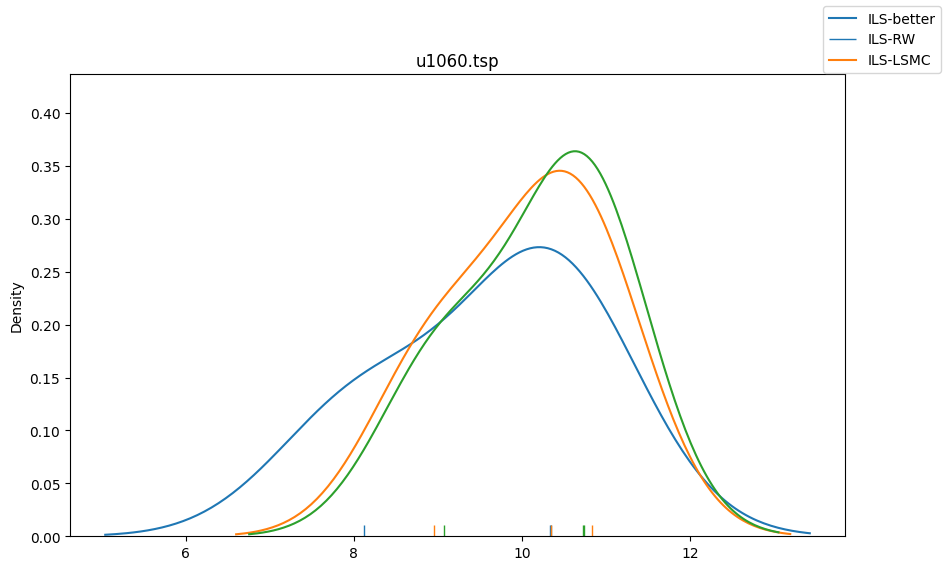

In [11]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data = pd.DataFrame.from_dict(samples[instance][improve], orient='index').transpose()
      data_avg = data.mean(axis = 0, skipna = True)
      sns.distplot(data_avg, rug=True, hist=False)

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()